In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor  # Thêm import này ngay từ đầu
from sklearn.metrics import mean_squared_error, r2_score
import glob
import os

def convert_number(value):
    if isinstance(value, str):
        value = value.replace(',', '').strip()
        
        if value == '--':
            return np.nan
            
        multiplier = {
            'T': 1e12,
            'B': 1e9,
            'M': 1e6
        }
        
        for unit, mult in multiplier.items():
            if value.endswith(unit):
                try:
                    return float(value[:-1]) * mult
                except ValueError:
                    return np.nan
                
        try:
            return float(value)
        except ValueError:
            return np.nan
    return value

# Đọc dữ liệu với xử lý lỗi
def load_data(data_path):
    csv_files = glob.glob(data_path)
    if not csv_files:
        raise ValueError(f"No CSV files found in {data_path}")
        
    dataframes = []
    for file in csv_files:
        try:
            df = pd.read_csv(file)
            symbol = os.path.basename(file).split('_')[-1].split('.')[0]
            df['Symbol'] = symbol
            
            numeric_cols = df.columns[1:-1]
            for col in numeric_cols:
                df[col] = df[col].apply(convert_number)
                
            dataframes.append(df)
            print(f"Successfully loaded {file}")
        except Exception as e:
            print(f"Error loading {file}: {e}")
    
    return pd.concat(dataframes, ignore_index=True)

# Sử dụng hàm load_data
try:
    data = load_data('../Data/*.csv')
    print("\nData shape:", data.shape)
    print("\nFirst few rows:")
    print(data.head())
    print("\nMissing values:")
    print(data.isnull().sum())
except Exception as e:
    print(f"Error processing data: {e}")

Successfully loaded ../Data\detail_data_APP.csv
Successfully loaded ../Data\detail_data_APPS.csv
Successfully loaded ../Data\detail_data_ARM.csv
Successfully loaded ../Data\detail_data_BROS.csv
Successfully loaded ../Data\detail_data_CYN.csv
Successfully loaded ../Data\detail_data_DDOG.csv
Successfully loaded ../Data\detail_data_DNUT.csv
Successfully loaded ../Data\detail_data_DUK.csv
Successfully loaded ../Data\detail_data_ELF.csv
Successfully loaded ../Data\detail_data_ENSC.csv
Successfully loaded ../Data\detail_data_GOOS.csv
Successfully loaded ../Data\detail_data_HAL.csv
Successfully loaded ../Data\detail_data_HSY.csv
Successfully loaded ../Data\detail_data_JMIA.csv
Successfully loaded ../Data\detail_data_LYFT.csv
Successfully loaded ../Data\detail_data_MDJH.csv
Successfully loaded ../Data\detail_data_MELI.csv
Successfully loaded ../Data\detail_data_MRNA.csv
Successfully loaded ../Data\detail_data_QCOM.csv
Successfully loaded ../Data\detail_data_UBER.csv
Successfully loaded ../Data

In [3]:
# Bước 2: Xử lý Dữ liệu và Huấn luyện Mô hình

# Import các thư viện cần thiết (nếu chưa được import ở bước 1)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# In ra tên các cột để kiểm tra
print("\nColumns in dataframe:", data.columns.tolist())

# Xác định lại các chỉ số tài chính cần thiết
selected_metrics = ['Market Cap', 'Enterprise Value', 'Price/Sales', 'Price/Book', 'Forward P/E']
data_filtered = data[data['Unnamed: 0'].isin(selected_metrics)]

# Pivot table để chuyển đổi dữ liệu - bao gồm 'Current' và các mốc thời gian khác
data_pivoted = data_filtered.melt(
    id_vars=['Unnamed: 0', 'Symbol'],
    value_vars=['Current', '6/30/2024', '3/31/2024', '12/31/2023', '9/30/2023', '6/30/2023'],
    var_name='Date',
    value_name='Value'
)

# Pivot để tạo features với các chỉ số tài chính làm cột
data_wide = data_pivoted.pivot(
    index=['Symbol', 'Date'],
    columns='Unnamed: 0',
    values='Value'
).reset_index()

# Đổi tên các cột nếu cần thiết
data_wide.columns.name = None

# Chọn dữ liệu tại thời điểm 'Current'
data_current = data_wide[data_wide['Date'] == 'Current']

# Xác định features và target
features = ['Market Cap', 'Enterprise Value', 'Price/Sales', 'Price/Book']
target = 'Forward P/E'

# Loại bỏ các dòng có giá trị NaN
data_clean = data_current.dropna(subset=features + [target])

# Chia features và target
X = data_clean[features]
y = data_clean[target]

# Kiểm tra kích thước dữ liệu sau khi lọc
print(f"\nNumber of samples after cleaning: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")

# Chia tập train và test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Huấn luyện mô hình
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

print("\nTraining set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Model training completed successfully.")


Columns in dataframe: ['Unnamed: 0', 'Current', '6/30/2024', '3/31/2024', '12/31/2023', '9/30/2023', '6/30/2023', 'Symbol', '9/30/2024']

Number of samples after cleaning: 17
Number of features: 4

Training set shape: (13, 4)
Test set shape: (4, 4)
Model training completed successfully.



Mean Squared Error (MSE): 93585.9372652425
Mean Absolute Error (MAE): 165.140175
R2 Score: -0.35046555543949576


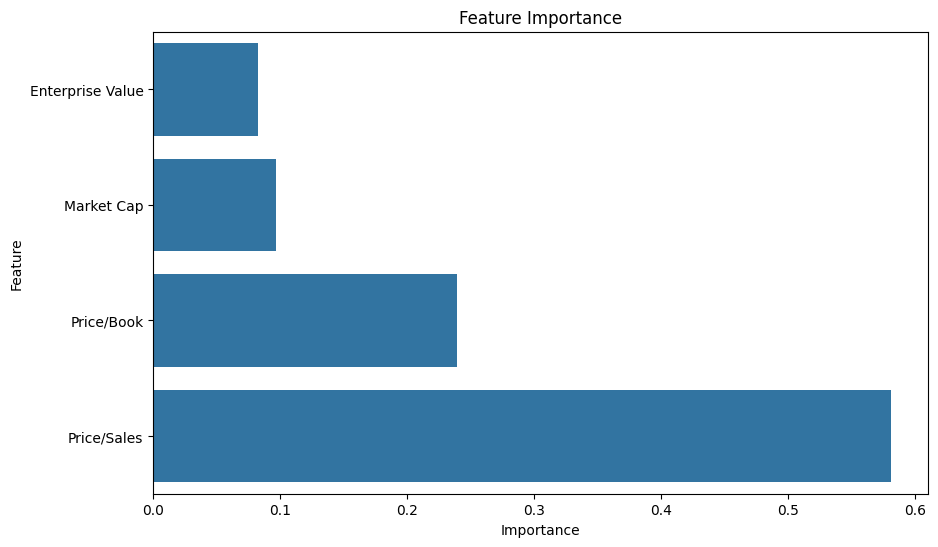

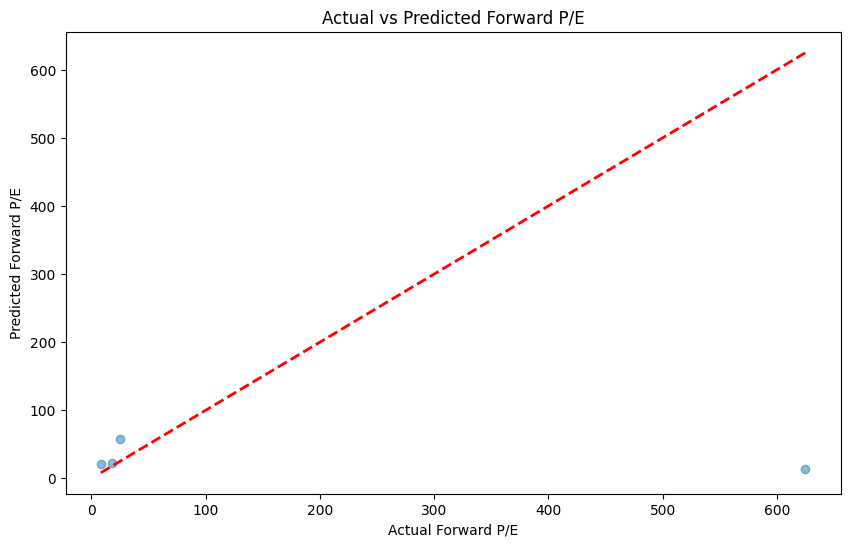


Top 5 prediction errors:
     Actual  Predicted     Error
131  625.00    14.1885  610.8115
5     25.32    58.1398   32.8198
11     8.31    20.8132   12.5032
47    18.02    22.4462    4.4262


In [4]:
# Bước 3: Dự Đoán và Đánh Giá Mô hình

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# Dự đoán trên tập test sử dụng mô hình đã huấn luyện
y_pred = model.predict(X_test_scaled)

# Đánh giá mô hình
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'\nMean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R2 Score: {r2}')

# Plot Feature Importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=True)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Plot Predicted vs Actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Forward P/E')
plt.ylabel('Predicted Forward P/E')
plt.title('Actual vs Predicted Forward P/E')
plt.show()

# Hiển thị các lỗi dự đoán lớn nhất
data_errors = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Error': np.abs(y_test - y_pred)
}).sort_values(by='Error', ascending=False)

print("\nTop 5 prediction errors:")
print(data_errors.head(5))

In [7]:
# Bước 4: Dự Đoán cho Dữ Liệu Mới

# Hàm để dự đoán cho dữ liệu mới
def predict_stock(market_cap, enterprise_value, price_sales, price_book, scaler, model):
    input_data = np.array([[market_cap, enterprise_value, price_sales, price_book]])
    input_scaled = scaler.transform(input_data)
    prediction = model.predict(input_scaled)
    return prediction[0]

# Chọn mã cổ phiếu muốn dự đoán
available_symbols = data_clean['Symbol'].unique()
print("\nAvailable symbols for prediction:", available_symbols)

# Nhập mã cổ phiếu muốn dự đoán từ người dùng
# Trong Jupyter Notebook, bạn có thể sử dụng input(), nhưng để tự động hóa, hãy chọn một symbol
symbol_to_predict = 'UBER'  # Thay bằng mã cổ phiếu bạn muốn hoặc lấy từ danh sách

# Lọc dữ liệu cho cổ phiếu đó
example_data = data_clean[data_clean['Symbol'] == symbol_to_predict]

if not example_data.empty:
    example_data = example_data.iloc[0]
    
    print("\nExample data being used:")
    print(f"Symbol: {example_data['Symbol']}")
    print(f"Date: {example_data['Date']}")
    print("\nFeature values:")
    for feature in features:
        print(f"{feature}: {example_data[feature]:.2e}")
    
    # Dự đoán sử dụng mô hình đã train
    new_prediction = predict_stock(
        market_cap=example_data['Market Cap'],
        enterprise_value=example_data['Enterprise Value'],
        price_sales=example_data['Price/Sales'],
        price_book=example_data['Price/Book'],
        scaler=scaler,
        model=model
    )
    
    print(f'\nPredicted Forward P/E: {new_prediction:.2f}')
    print(f'Actual Forward P/E: {example_data["Forward P/E"]:.2f}')
    print(f'Prediction Error: {abs(new_prediction - example_data["Forward P/E"]):.2f}')
else:
    print(f"No data available for symbol {symbol_to_predict}")


Available symbols for prediction: ['APP' 'APPS' 'ARM' 'BROS' 'DDOG' 'DUK' 'ELF' 'GOOS' 'HAL' 'HSY' 'LYFT'
 'MELI' 'QCOM' 'UBER' 'VST' 'WBD' 'Z']

Example data being used:
Symbol: UBER
Date: Current

Feature values:
Market Cap: 1.57e+11
Enterprise Value: 1.60e+11
Price/Sales: 3.80e+00
Price/Book: 1.06e+01

Predicted Forward P/E: 26.87
Actual Forward P/E: 29.07
Prediction Error: 2.20


c:\Users\vuduy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
